# Real-Time Wildlife Alert System: Example Tutorial Notebook
Thomas Ratsakatika | AI and Environment Researcher | University of Cambridge

Last updated: 10 March 2025

## Introduction

This notebook will walk you through how to set up and use the advanced version of the wildlife alert system.

**Steps 1 and 2** let you experiment with the alert system using photos stored on your computer.

**Steps 3 to 5** walk you through setting up the system to receive emails from a 4G-enabled camera trap.

If you have any queries or feedback, please contact [Tom Ratsakatika](mailto:trr26@cam.ac.uk).

## Step 1: Import Modules and AI Models

First, ensure you have cloned (copied) the repository to your device, created a virtual environment and installed the required modules by following the instructions in the [README](../README.md#-example-tutorial).

You should then be able to run the cell below, which imports the modules required to run the alert system. 

In [ ]:
### Import required modules ###

from PytorchWildlife.models import detection as pw_detection # MegaDetector object detection model

import pandas as pd             # Data manipulation and analysis
import time                     # Time functions
from datetime import datetime   # Date and time manipulation
import schedule                 # Schedule function for weekly reports
import functools                # Function for weekly reports
import sys                      # System parameters and functions
import os                       # Functions for interacting with the operating system
sys.path.append('../scripts')   # Add scripts directory to system path

### Import modules required for the the example ### 

from IPython.display import display, HTML  # Function to display images in Jupyter notebooks
import tkinter as tk            # Tkinter GUI toolkit
from tkinter import filedialog  # File dialog for opening files
from PIL import Image           # Python Imaging Library (PIL)
from io import BytesIO          # Handle binary data in memory
import base64                   # Encode binary data for HTML display

### Import alert system functions from ../scripts/alert_system_utils.py ###

from alert_system_utils import (

    ### Functions to download photos and metadata from emails ###

    current_time,               # Get the current time
    check_emails,               # Checks for new emails, extracts photos and metadata
    extract_and_update_camera_info,  # Extract and update camera information
    update_camera_data_dataframe,    # Update camera data DataFrame

    ### Functions to detect and classify animals in photos ###

    set_device,                 # Sets computation device (CPU/GPU)
    detector,                   # Animal/human/vehicle detection
    classifier,                 # Animal classification model
    batch_classification,       # Batch classification of images
    detections_in_sequence,     # Checks if anything has been detected

    ### Functions to annotate photos and send an alert to Telegram ###

    generate_alert_caption_en,     # Generate captions for alerts (English)
    generate_alert_caption_ro,     # Generate captions for alerts (Romanian)
    send_alert_to_telegram,        # Send alerts to Telegram
    annotate_images_en,            # Annotate images with detection results (English)
    annotate_images_ro,            # Annotate images with detection results (Romanian)

    ### Functions to save the photos and send weekly reports ###
    save_images,                   # Save images to disk
    send_weekly_report,            # Send a weekly report

    #### Function to load the settings from the configuration file
    load_config                    # Loads configuration file settings
)

Now you can initialise the detection and classification models. Download these two models and move them into the [models](../models/) folder.

- MegaDetector Detection Model: <a href="https://github.com/agentmorris/MegaDetector/releases/tag/v5.0" target="_blank">md_v5a.0.0.pt</a> (268MB)
- DeepFaune Classifier Model: <a href="https://pbil.univ-lyon1.fr/software/download/deepfaune/v1.1/" target="_blank">deepfaune-vit_large_patch14_dinov2.lvd142m.pt</a> (1.2GB)

The alert system follows a two-stage detection and classification process. The detection model specalises in detecting animals, humans and vehicles in photos, and determining their location with bounding boxes. The classification model specialises in determining the species of animals.

Run the cell below to initialise the detection and classifiaction models. The code will automatically use a NVIDIA GPU if you have one.

In [ ]:
###############################################################
####### INITIALISE DETECTION AND CLASSIFICATION MODELS ########
###############################################################

# Set Device - GPU or CPU
device = set_device()

# Detection Model Settings

DETECTOR_MODEL_V6 = False   # True = v6, False = v5
DETECTOR_CLASSES = ["animal", "human", "vehicle"]

print(f"Loading detector...")
if DETECTOR_MODEL_V6:
    weights = os.path.join("../models/MDV6-yolov10x.pt")
    detector_model = pw_detection.MegaDetectorV6(device=device, weights=weights, pretrained=True, version="MDV6-yolov10-e")
    detector_model.predictor.args.verbose = False
    print("Using MegaDetector v6 (MDV6-yolov9-e)")
else:
    weights = os.path.join("../models/md_v5a.0.0.pt")
    detector_model = pw_detection.MegaDetectorV5(device=device, weights=weights, pretrained=True, version="a")
    print("Using MegaDetector v5 (md_v5a.0.0)")

# Classification Model Settings
BACKBONE = 'vit_large_patch14_dinov2'

BACKBONE = 'vit_large_patch14_dinov2'
CLASSIFIER_MODEL_PATH = '../models/deepfaune-vit_large_patch14_dinov2.lvd142m.v3.pt'  # Update to the new model path if needed

CLASSIFIER_CLASSES = [
    "Bison", "Badger", "Ibex", "Beaver", "Red Deer", "Chamois", "Cat",
    "Goat", "Roe Deer", "Dog", "Fallow Deer", "Squirrel", "Moose",
    "Equid", "Genet", "Wolverine", "Hedgehog", "Lagomorph", "Wolf",
    "Otter", "Lynx", "Marmot", "Micromammal", "Mouflon", "Sheep",
    "Mustelid", "Bird", "Bear", "Nutria", "Raccoon", "Fox",
    "Reindeer", "Wild Boar", "Cow"
]

ROMANIAN_CLASSES = [
    "Bizon", "Bursuc", "Ibex", "Castor", "Cerb", "Capră Neagră", "Pisică",
    "Capră", "Căprioară", "Câine", "Cerb Lopătar", "Veveriță", "Elan",
    "Cal", "Genetă", "Jder Mare", "Arici", "Iepure", "Lup",
    "Vidră", "Râs", "Marmotă", "Micromamifer", "Muflon", "Oaie",
    "Mustelid", "Pasăre", "Urs", "Nutrie", "Raton", "Vulpe",
    "Ren", "Mistreț", "Vacă"
]

print(f"\nLoading classifier...")
start_time = time.time()
classifier_model = classifier(CLASSIFIER_MODEL_PATH, BACKBONE, CLASSIFIER_CLASSES, device)
end_time = time.time()
print(f"Loaded classifier in {(end_time - start_time):.2f} seconds. Device: {device}")

## Step 2: Test Your Setup on Example Photos

Before testing the system on some photos, we need to set the models' thresholds. These can be set between 0 and 1.

A lower **detection** threshold will mean the system is more sensitive, but it might think that objects such as log or a tree stump are animals when they are not. A higher detection threshold will mean that you get fewer false positives, but the system may miss difficult to detect animals (e.g. nighttime or blurry images).

A lower **classification** threshold will mean that the system will be more likely to try and classify an animal detection, even if it isn't sure. A higher classification threshold will mean that the model will label more animal detections as "unknown".

We also need to set the alert system language (currently English or Romanian), and the times during which we want to receive photos of people or vehicles. The latter is a privacy feature, to prevent the system from sending photos of the general public during daylight hours.

**When deploying the alert system, these parameters are set in the [config.yaml](../config.yaml.example) file (rename config.yaml.example to config.yaml).**

In [ ]:
if DETECTOR_MODEL_V6:
    DETECTION_THRESHOLD = 0.25      # Detection threshold - recommended 0.25 for v6
else:
    DETECTION_THRESHOLD = 0.15      # Detection threshold - recommended 0.15 for v5

CLASSIFICATION_THRESHOLD = 0.30     # Classification threshold - recommend set between 0.2 to 0.8 depending on tolerance for false positives

# Alert Message Settings
ALERT_LANGUAGE = "en"               # Curently English (en) and Romanian (ro) are supported

Now you can run the cell below to run the system on a photo(s) on your device. Note how the first detects the number of objects, and then itterates through each detection in each photo using the classifier.

You can select more than one photo by holding down CTRL and click on multiple files. This mimics how the alert system may receive photos from a 4G camera trap in the field. *Note that the system does not expect to see bears and wild boars together, so if you select both, it will only count the first species it sees in the alert message header.*

In [ ]:
# Function to open file dialog and select one or more JPG images
def open_images():
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    root.geometry("800x600")  
    initial_dir = '../data/example_photos'  # Set initial directory for file dialog
    # Open file dialog to select one or more JPG files
    file_paths = filedialog.askopenfilenames(initialdir=initial_dir, title="Select file(s)",
                                             filetypes=[("JPEG files", "*.jpg"), 
                                                        ("JPEG files", "*.jpeg"), 
                                                        ("JPEG files", "*.JPG"), 
                                                        ("JPEG files", "*.JPEG")])
    # Open and return the selected images as a list of PIL Image objects
    return [Image.open(file_path) for file_path in file_paths] if file_paths else []


# Call the function and store the selected images in a list
images = open_images()

# Print the number of selected images
print(f"{current_time()} | {len(images)} image(s) selected")


# Load the capture database into a DataFrame, df
# This DataFrame is required to manage data in the subsequent steps
CAPTURE_DATABASE_PATH = '../data/capture_database.csv' 
df = pd.read_csv(CAPTURE_DATABASE_PATH)

# Loop to add dummy rows to the DataFrame for this example
for _ in range(len(images)):
    new_row = pd.DataFrame([[0, 1] + [0] * 10 + [None] * (len(df.columns) - 12)], columns=df.columns)
    df = pd.concat([df, new_row], ignore_index=True)

# Detect animals, humans and/or vehicles in the image(s) using the MegaDetector detection model
df, human_warning = detector(df, detector_model, images, DETECTION_THRESHOLD)

# Classify objects in the image(s) using the DeepFaune classification model
df, priority_detections = batch_classification(df, classifier_model, images, CLASSIFICATION_THRESHOLD)

# Check if there are any detections in the sequence above the threshold
if detections_in_sequence(df, images, CLASSIFICATION_THRESHOLD):

    # Generate an alert caption based on the detections
    df, alert_caption = generate_alert_caption_en(df, human_warning, len(images), priority_detections, CLASSIFICATION_THRESHOLD)

    # Annotate images with bounding boxes, labels and confidence levels
    images = annotate_images_en(df, images, CLASSIFICATION_THRESHOLD)

# Display the images in Jupyter notebook
if images:
    html = "<div style='display: flex; flex-wrap: wrap;'>"
    for img in images:
        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        html += f"<div style='margin: 10px;'><img src='data:image/jpeg;base64,{img_str}' width='600px' /></div>"
    html += "</div>"
    display(HTML(html))

# Display the alert message in Jupyter notebook
alert_html = f"<div style='padding: 10px; background-color: white; border: 1px solid black; white-space: pre-wrap; color: black; width: 600px;'>{alert_caption}</div>"
display(HTML(alert_html))


## Step 3: Set Up an Alert System Email Account and Telegram Group


### Email Setup

To set up the system so that it can receive emails from a 4G camera trap, you need to create a dedicated email account to receive the camera trap images. Your email provider **must** support app passwords (e.g. <a href="https://myaccount.google.com/apppasswords" target="_blank">Gmail</a>). Create an app password and keep a record of it. Then set up your 4G camera trap to send photos to this dedicated email address.

### Telegram Setup

Setup Telegram on your mobile device. Create a bot in Telegram using @BotFather and note down the bot token. Detailed instructions on how to do this can be <a href="https://core.telegram.org/bots/tutorial" target="_blank">found here</a>.

Create a group in Telegram, add the bot to the group and make it an admin. Then note down the group's <a href="https://www.wikihow.com/Know-Chat-ID-on-Telegram-on-Android" target="_blank">chat ID</a> (do this AFTER adding the bot - the chat ID should start with '#-100')

### Update the Config.yaml file

Open the [config.yaml.example](../config.yaml.example) file in a text editor. It should be in this format.

```
imap_config:
  host: 'YOUR_IMAP_SERVER_NAME'
  user: 'YOUR_DEDICATED_EMAIL_ADDRESS'
  password: 'YOUR_APP_PASSWORD'

telegram_config:
  bot_token: 'YOUR_BOT_TOKEN'
  chat_id: 'YOUR_CHAT_ID'

smtp_config:
  host: 'YOUR_SMTP_SERVER_NAME'
  port: 'YOUR_SMTP_SERVER_PORT'
  user: 'YOUR_DEDICATED_EMAIL_ADDRESS'
  password: 'YOUR_APP_PASSWORD'
  recipients:
    - 'RECIPIENT_EMAIL_ADDRESS_1'
    - 'RECIPIENT_EMAIL_ADDRESS_2'

telegram_config:
  bot_token: 'YOUR_BOT_TOKEN'
  chat_id_all: 'YOUR_CHAT_ID'
  chat_id_priority: 'YOUR_CHAT_ID'
  chat_id_human: 'YOUR_CHAT_ID'

system_config:
  LANGUAGE: 'en' # Enter EN for English and RO for Romanian
  CHECK_EMAIL_FREQUENCY: 60 # How often the system checks emails in seconds (default = 60)
  DETECTION_THRESHOLD: 0.20
  DETECTOR_MODEL_V6: False # True = MegaDetector v6, False = MegaDetector v5
  CLASSIFICATION_THRESHOLD: 0.60
  PRIORITY_SPECIES:
    - 'Wolf'
    - 'Bear'
    - 'Wild Boar'
```

Update the settings with your email providers imap and smtp settings, and your Telegram bot token and chat ID.

The 'recipients' under smtp_config are the email addresses that will receive a regular report. You can change when and how often the regular report is sent in the next cell.

**IMPORTANT: Save your updated configuration file as config.yaml (i.e. _not_ config.yaml.example)**

**DO NOT share your config.yaml file with anyone as it contains passwords necessary to access your dedicated email account.**

### Update the camera(s) details

Update the [camera locations](data/camera_locations.csv) CSV file with your camera(s) details, location and a google maps link.

You can add as many cameras as you like.

### Load your configuration

Run the cell below to load your configuration.

In [ ]:
#################################################
###### INITIALISE SETTINGS AND FILE PATHS #######
#################################################

# Locations of capture database, camera location tables, and storage folder for photos received by the alert system
CAPTURE_DATABASE_PATH = '../data/capture_database.csv' 
CAMERA_LOCATIONS_PATH = '../data/camera_locations.csv'
PHOTOS_PATH = '../data/photos/'

# Load configuration from file
CONFIG_PATH = '../config.yaml'
config = load_config(CONFIG_PATH)

# Extract the variables from the returned dictionary
DETECTION_THRESHOLD = config['DETECTION_THRESHOLD']
DETECTOR_MODEL_V6 = config['DETECTOR_MODEL_V6']
CLASSIFICATION_THRESHOLD = config['CLASSIFICATION_THRESHOLD']
ALERT_LANGUAGE = config['ALERT_LANGUAGE']
PRIORITY_SPECIES = config['PRIORITY_SPECIES']
CHECK_EMAIL_FREQUENCY = config['CHECK_EMAIL_FREQUENCY']
IMAP_HOST = config['IMAP_HOST']
EMAIL_USER = config['EMAIL_USER']
EMAIL_PASS = config['EMAIL_PASS']
TELEGRAM_BOT_TOKEN = config['TELEGRAM_BOT_TOKEN']
TELEGRAM_CHAT_ID_ALL = config['TELEGRAM_CHAT_ID_ALL']
TELEGRAM_CHAT_ID_PRIORITY = config['TELEGRAM_CHAT_ID_PRIORITY']
TELEGRAM_CHAT_ID_HUMAN = config['TELEGRAM_CHAT_ID_HUMAN']
SMTP_SERVER = config['SMTP_SERVER']
SMTP_PORT = config['SMTP_PORT']
EMAIL_SENDER = config['EMAIL_SENDER']
EMAIL_PASSWORD = config['EMAIL_PASSWORD']
RECIPIENTS = config['RECIPIENTS']
last_config_mod_time = config['last_config_mod_time']

### Settings for regular report (default - weekly on Mondays at 08:00)
schedule.every().monday.at("08:00").do(
    functools.partial(send_weekly_report, SMTP_SERVER, EMAIL_SENDER, EMAIL_PASSWORD, SMTP_PORT, CAPTURE_DATABASE_PATH, CAMERA_LOCATIONS_PATH, RECIPIENTS, EMAIL_USER)
)

## Step 4: Test the System

You can now run the cell below to launch the alert system.

The code will check the email account every 60 seconds for unread emails, download any photos, detect and classify animals, and send an alert your Telegram Group.

It will then update the [capture database](data/capture_database.csv) and save the original photos in the [photos folder](data/photos).

A high level process flow diagramme is shown below the code.

In [ ]:
################################################
########### START ALERT SYSTEM LOOP ############
################################################

if __name__ == "__main__":
    print(f"\n{current_time()} | Monitoring {EMAIL_USER} for new messages...")
    while True:
        try:
            
            # Check for emails, extract metadata
            images, original_images, image_count, camera_id, temp_deg_c, img_date, img_time, battery, sd_memory = \
                check_emails(IMAP_HOST, EMAIL_USER, EMAIL_PASS)

            if camera_id:

                # Get the camera details from the camera_location database
                camera_make, gps, location, map_url, battery, sd_memory = extract_and_update_camera_info(CAMERA_LOCATIONS_PATH, camera_id, battery, sd_memory)
                
                if images:
                    
                    # If images are attached to the email, open the capture_database
                    df = pd.read_csv(CAPTURE_DATABASE_PATH)

                    # Update the capture database with rows for each image
                    df = update_camera_data_dataframe(df, image_count, camera_id, camera_make, img_date, img_time, temp_deg_c, battery, sd_memory, location, gps, map_url)
                    
                    # Run the detection model on each image
                    df, human_warning = detector(df, detector_model, images, DETECTION_THRESHOLD)
                    
                    # Run the classification model on each image
                    df, priority_detections = batch_classification(df, classifier_model, images, CLASSIFICATION_THRESHOLD, PRIORITY_SPECIES)
                    
                    # Checks if there are any animal detections > CLASSIFICATION_THRESHOLD or human/vehicle detections of any confidence level
                    if detections_in_sequence(df, images, CLASSIFICATION_THRESHOLD):

                        # Generate an alert in English or Romanian
                        if ALERT_LANGUAGE == "ro":

                            df, alert_caption = generate_alert_caption_ro(df, human_warning, image_count, priority_detections, CLASSIFICATION_THRESHOLD, CLASSIFIER_CLASSES, ROMANIAN_CLASSES)                        
                            alert_images = annotate_images_ro(df, images, CLASSIFICATION_THRESHOLD, CLASSIFIER_CLASSES, ROMANIAN_CLASSES)

                        else: # Default to English

                            df, alert_caption = generate_alert_caption_en(df, human_warning, image_count, priority_detections, CLASSIFICATION_THRESHOLD)
                            alert_images = annotate_images_en(df, images, CLASSIFICATION_THRESHOLD)

                        if human_warning:
                            send_alert_to_telegram(TELEGRAM_BOT_TOKEN, TELEGRAM_CHAT_ID_HUMAN, alert_images, alert_caption)
                            print(f"{current_time()} | Alert sent to people/vehicle group.")
                            
                            if TELEGRAM_CHAT_ID_ALL != TELEGRAM_CHAT_ID_HUMAN:
                                send_alert_to_telegram(TELEGRAM_BOT_TOKEN, TELEGRAM_CHAT_ID_ALL, None, alert_caption)
                                print(f"{current_time()} | Alert sent to all animals group (photos withheld).")
                        
                        elif priority_detections:
                            send_alert_to_telegram(TELEGRAM_BOT_TOKEN, TELEGRAM_CHAT_ID_PRIORITY, alert_images, alert_caption)
                            print(f"{current_time()} | Alert sent to priority animals group")
                            
                            if TELEGRAM_CHAT_ID_ALL != TELEGRAM_CHAT_ID_PRIORITY:
                                send_alert_to_telegram(TELEGRAM_BOT_TOKEN, TELEGRAM_CHAT_ID_ALL, alert_images, alert_caption)
                                print(f"{current_time()} | Alert sent to all animals group")
                        
                        else:
                            send_alert_to_telegram(TELEGRAM_BOT_TOKEN, TELEGRAM_CHAT_ID_ALL, alert_images, alert_caption)
                            print(f"{current_time()} | Alert sent to all animals group")
                            
                    else:
                        
                        print(f"{current_time()} | All photos in sequence are empty")
                    
                    # Save the original photos the the ../data/photos/ folder
                    df = save_images(df, original_images, human_warning, PHOTOS_PATH, CLASSIFICATION_THRESHOLD)
                    
                    # Update the capture_database
                    df.to_csv(CAPTURE_DATABASE_PATH, index=False)
                    print(f"{current_time()} | Capture database updated: {CAPTURE_DATABASE_PATH}")
                    
                    # Clear the dataframe to free up memory
                    del df
                
                else:
                    
                    print(f"{current_time()} | No images attached to email")
                
                print(f"\n{current_time()} | Monitoring {EMAIL_USER} for new messages...")
            
            else:
                # Wait before checking emails again
                time.sleep(CHECK_EMAIL_FREQUENCY)
            
            # Check to see if it is time to send the regular report
            schedule.run_pending()

            # Check for updates to the config file
            current_config_mod_time = os.path.getmtime(CONFIG_PATH)

            if current_config_mod_time != last_config_mod_time:
                print(f"{current_time()} | Configuration File Updated")
                print(f"{current_time()} | Original Settings: "
                    f"DETECTION_THRESHOLD={DETECTION_THRESHOLD}, CLASSIFICATION_THRESHOLD={CLASSIFICATION_THRESHOLD}, "
                    f"ALERT_LANGUAGE={ALERT_LANGUAGE}, CHECK_EMAIL_FREQUENCY={CHECK_EMAIL_FREQUENCY} seconds, "
                    f"HUMAN_ALERT_START={HUMAN_ALERT_START}. HUMAN_ALERT_END={HUMAN_ALERT_END}, "
                    f"PRIORITY_SPECIES={PRIORITY_SPECIES}")
                load_config(CONFIG_PATH)
                last_config_mod_time = current_config_mod_time

        except KeyboardInterrupt:
            print(f"{current_time()} | Interrupted by user")
            break
        
        # Error handling to keep the system running if an error occurs
        except Exception as e:
            print(f"{current_time()} | An error occurred: {e}")
            time.sleep(CHECK_EMAIL_FREQUENCY)
            print(f"\n{current_time()} | Monitoring {EMAIL_USER} for new messages...")
            continue

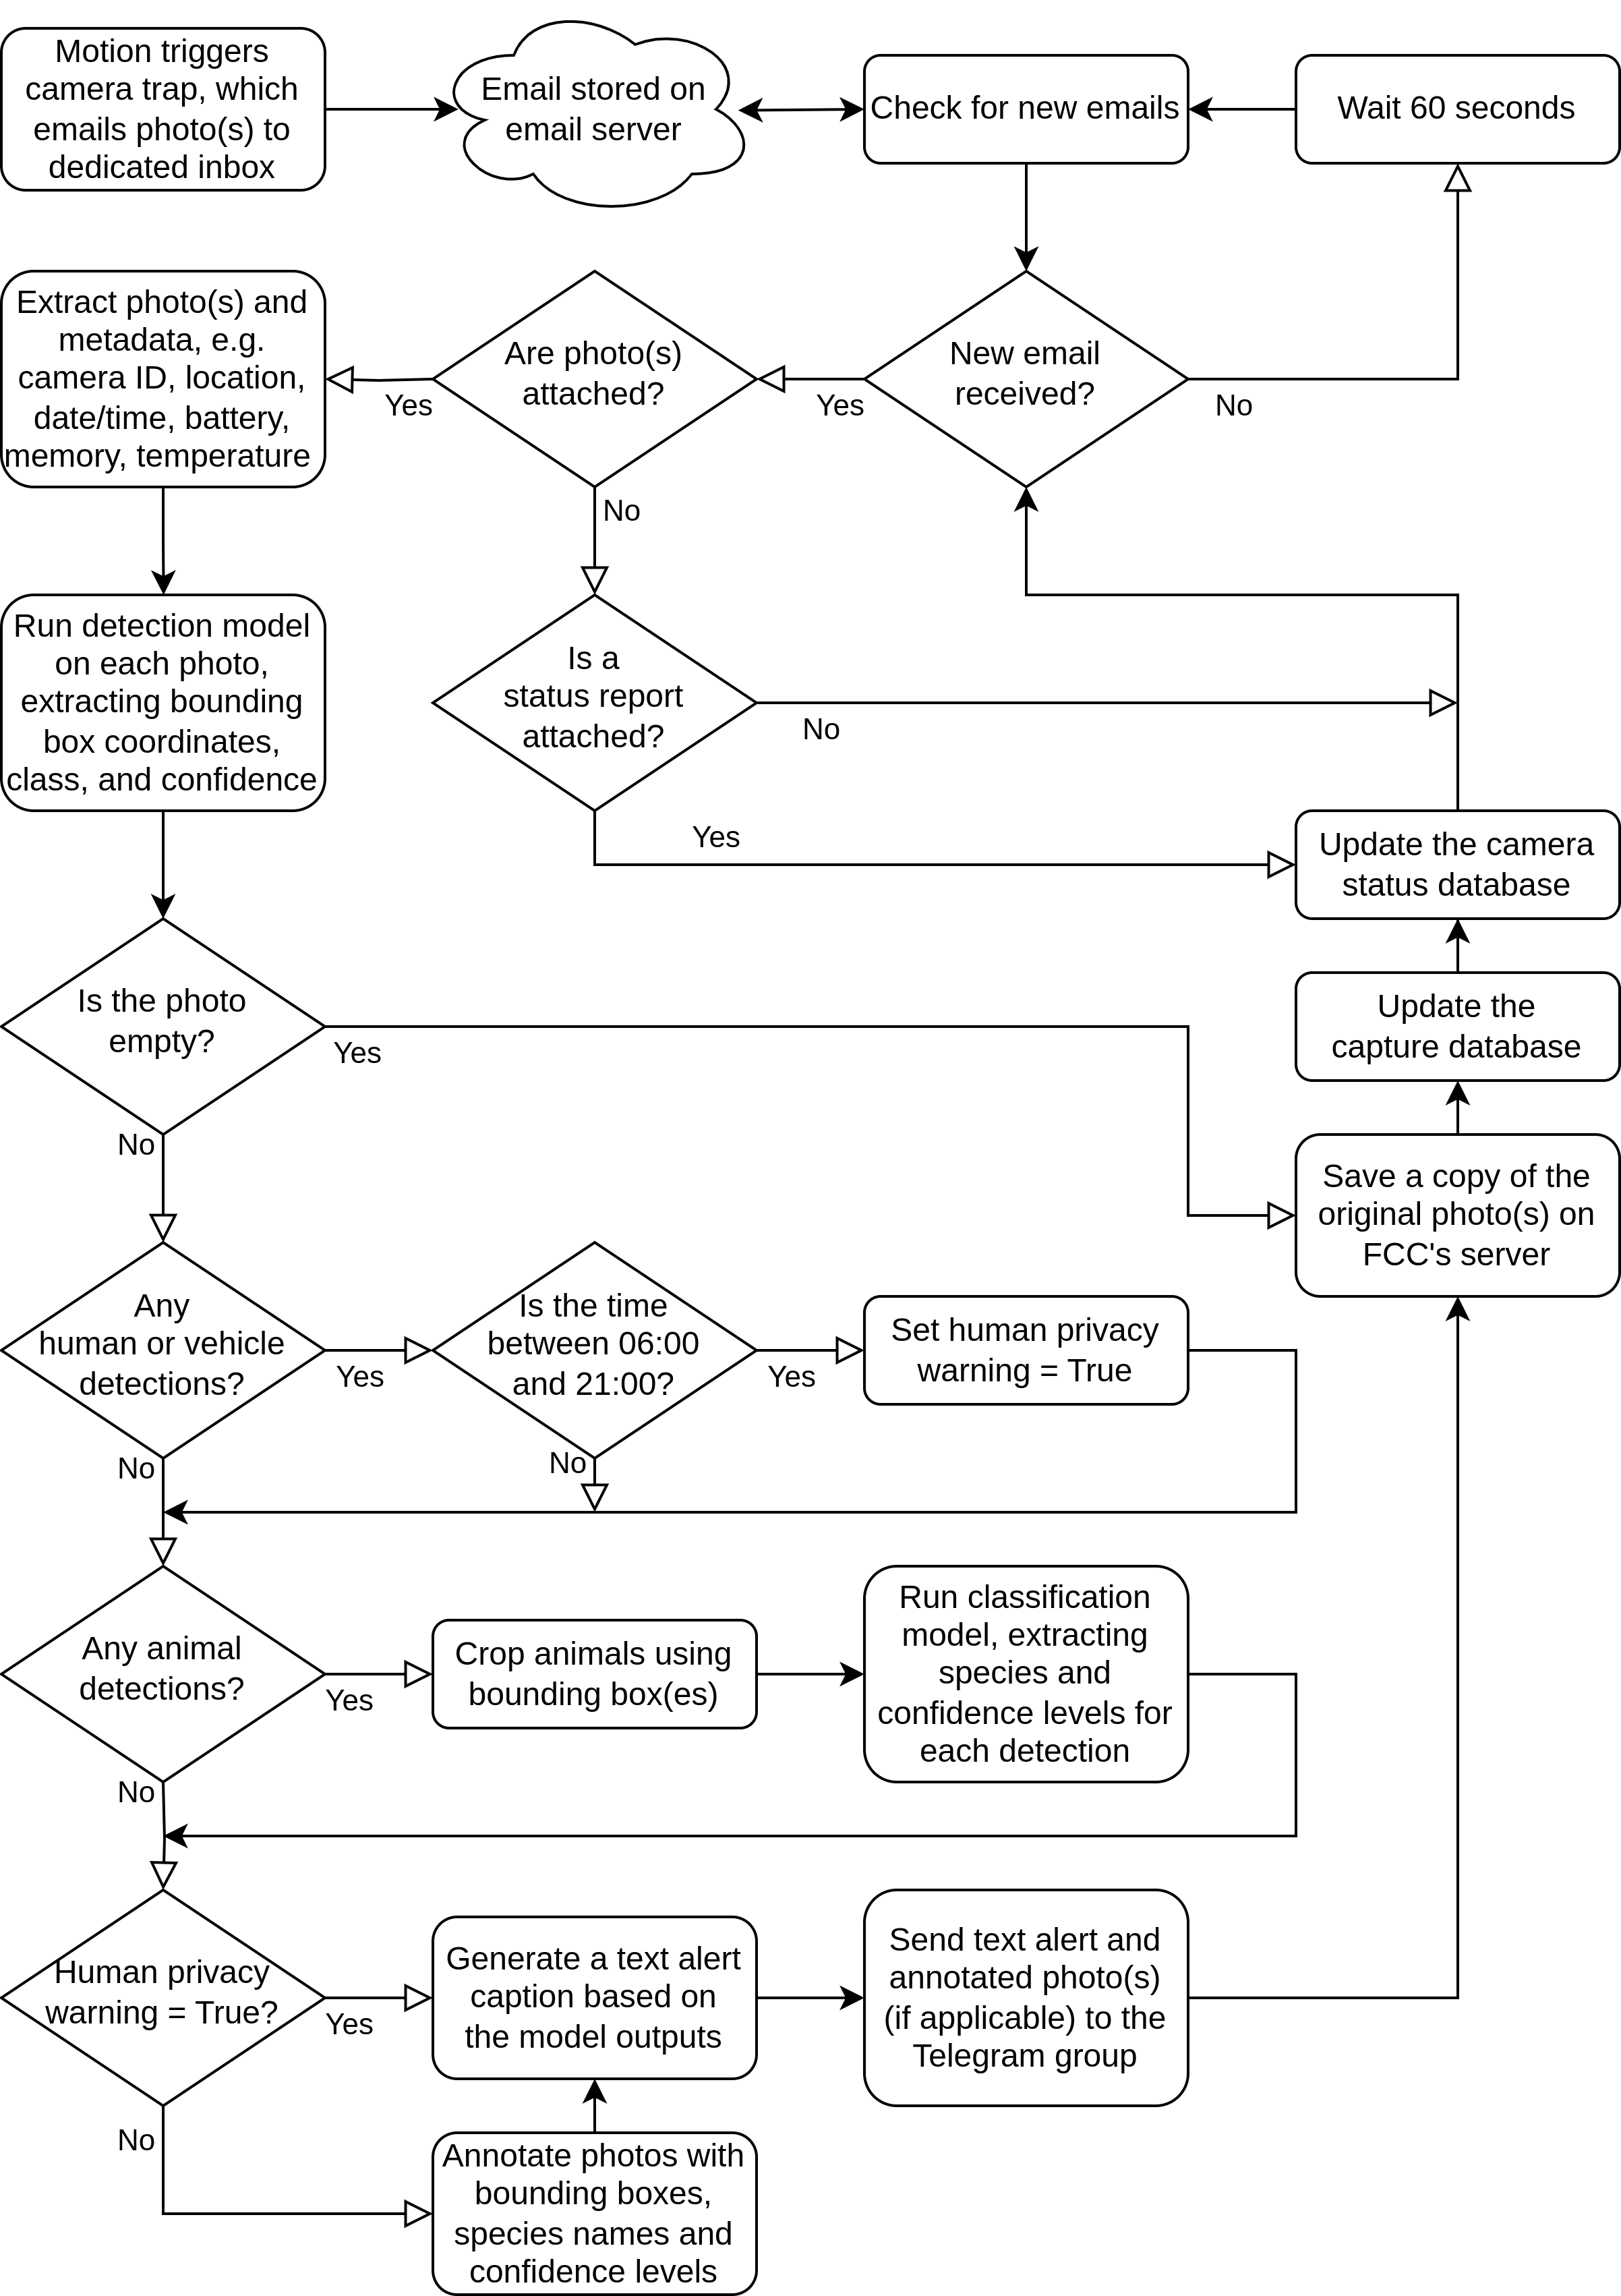

## Step 5: Deploy Your Script

That's it. The code in this notebook is identical to the [advanced_alert_system.py](../scripts/advanced_alert_system.py) script, which you can now edit to align with your required settings.

You need to run the [advanced_alert_system.py](../scripts/advanced_alert_system.py) script on a device that can be left on constantly. This may be an old computer or a virtual machine on your server. Consult your IT team to determine the best option.

You could alternatively run the [basic_alert_system.py](../scripts/basic_alert_system.py) script on a Raspberry Pi 4B. The logic is similar to this advanced system, however the models and messages are simpler. A Raspberry Pi 5 may even be able to run the advanced version, although this has not been tested.